In [1]:
import jax
import jaxgboost

import optax

import numpy as np
import matplotlib.pyplot as plt
from sklearn import datasets, metrics

In [2]:
data = datasets.load_diabetes()
x = data['data']
y = data['target'].reshape(-1, 1)

xt, yt = x[:400], y[:400]
xv, yv = x[400:], y[400:]

ym = yt.mean()
ys = yt.std() + 1e-6

yt = (yt - ym) / ys
yv = (yv - ym) / ys

xt = jax.numpy.array(xt)
xv = jax.numpy.array(xv)
yt = jax.numpy.array(yt)
yv = jax.numpy.array(yv)

In [3]:
static_params = {
    "n_estimators": 100,
    "max_depth": 4,
    "base_score": yt.mean(),
    "jit": False
}


def train_and_eval(params):    
    model = jaxgboost.JAXGBoostModel(**params, **static_params)
    model.fit(xt, yt)
    pv = model.predict(xv)
    valid_mse = jax.numpy.mean((yv - pv) ** 2)
    return valid_mse


value_and_grad = jax.value_and_grad(train_and_eval)

@jax.jit
def train_loop(params, opt_state):
    def step(i, state):
        _, params, opt_state = state

        value, grads = value_and_grad(params)
        
        updates, opt_state = optimizer.update(grads, opt_state)
        params = optax.apply_updates(params, updates)

        return value, params, opt_state

    value, params, opt_state = jax.lax.fori_loop(0, 10, step, (0.0, params, opt_state))
    return value, params, opt_state

In [4]:
params = {
    "learning_rate": 0.5,
    "max_delta_step": 0.1,
    "reg_alpha": 0.0,
    "reg_lambda": 1.0,
}
value = train_and_eval(params)
print(value, {k: np.round(float(v), 6) for k, v in params.items()})

optimizer = optax.adam(learning_rate=1e-3)
opt_state = optimizer.init(params)
values = [value]
params_history = []
for it in range(50):
    value, params, opt_state = train_loop(params, opt_state)
    values.append(value)
    params_history.append(params)

    params['reg_lambda'] = jax.numpy.clip(params['reg_lambda'], 0.0, 10.0)
    params['reg_alpha']  = jax.numpy.clip(params['reg_alpha'], 0.0, 10.0)

    print(value, {k: np.round(float(v), 6) for k, v in params.items()})

0.649431 {'learning_rate': 0.5, 'max_delta_step': 0.1, 'reg_alpha': 0.0, 'reg_lambda': 1.0}
0.56924874 {'learning_rate': 0.490835, 'max_delta_step': 0.092628, 'reg_alpha': 0.007609, 'reg_lambda': 1.008379}
0.5830088 {'learning_rate': 0.481516, 'max_delta_step': 0.084652, 'reg_alpha': 0.015384, 'reg_lambda': 1.016978}
0.57146347 {'learning_rate': 0.472429, 'max_delta_step': 0.076045, 'reg_alpha': 0.024353, 'reg_lambda': 1.026128}
0.5110769 {'learning_rate': 0.463894, 'max_delta_step': 0.065613, 'reg_alpha': 0.032761, 'reg_lambda': 1.034451}
0.55931497 {'learning_rate': 0.455156, 'max_delta_step': 0.055471, 'reg_alpha': 0.039983, 'reg_lambda': 1.041261}
0.544299 {'learning_rate': 0.446863, 'max_delta_step': 0.044059, 'reg_alpha': 0.047218, 'reg_lambda': 1.047614}
0.48350298 {'learning_rate': 0.441141, 'max_delta_step': 0.029407, 'reg_alpha': 0.052349, 'reg_lambda': 1.051817}
0.43401593 {'learning_rate': 0.43825, 'max_delta_step': 0.014366, 'reg_alpha': 0.055804, 'reg_lambda': 1.054668}
0

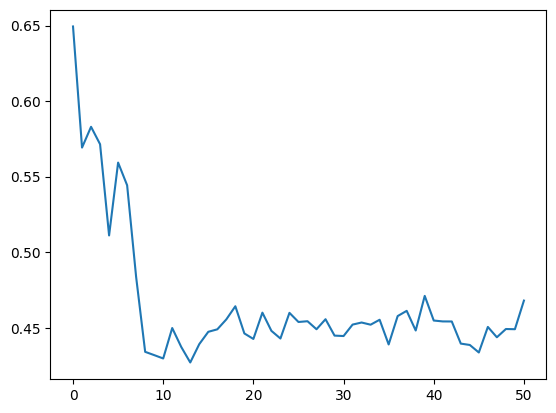

In [5]:
plt.plot(values)

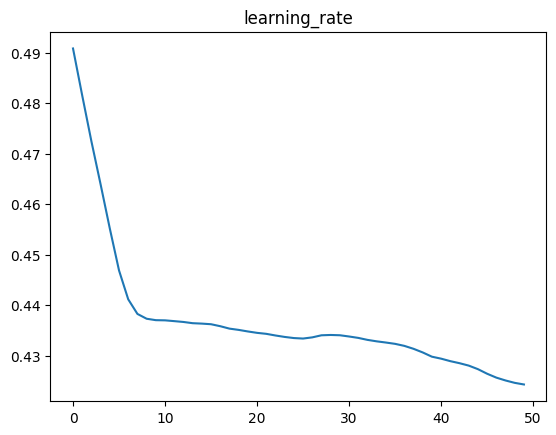

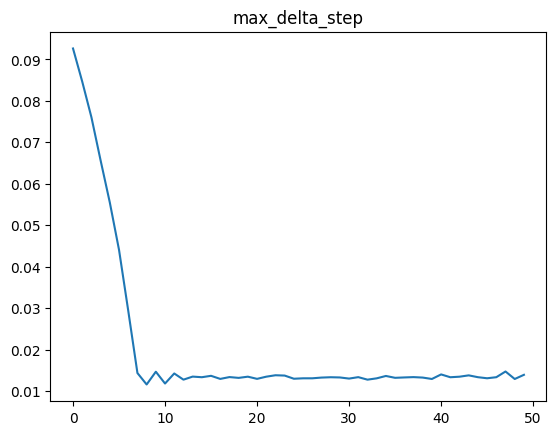

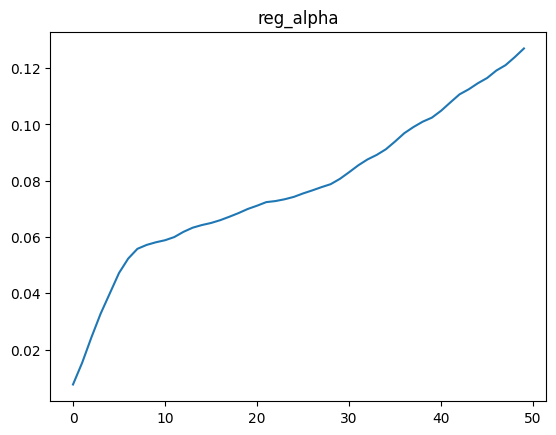

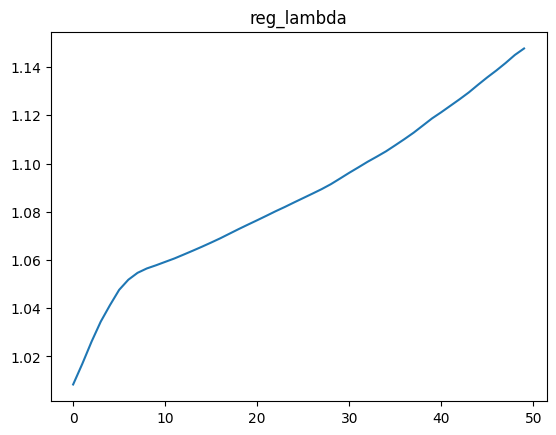

In [6]:
for k in params_history[0].keys():
    plt.figure()
    plt.tight_layout()
    plt.title(k)
    plt.plot([p[k] for p in params_history])